In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql
import importlib
from brokenaxes import brokenaxes

sys.path.append("..")
import analysislib as alib
importlib.reload(alib)

# ABOVE ZNONEOFTHE

sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12})

In [4]:
df_aha = pd.read_csv("../../data/2025-10-21-time-17-01-56-jvmheap-compression/zram_consolidated.csv")

# Get benchmarks ordered by their average data size
benchmarks_ordered = sqflat("""
    SELECT benchmark 
    FROM df_aha 
    GROUP BY benchmark 
    ORDER BY AVG(AVG_DATA_SIZE_MB)
""")

In [19]:
df_aha.columns

Index(['benchmark', 'device', 'AVG_COMPR_SIZE_MB', 'AVG_DATA_SIZE_MB',
       'AVG_HUGE_PAGES', 'AVG_INCOMPRESSIBLE_DATA_MB', 'AVG_RATIO',
       'AVG_SAME_PAGES', 'HUGE_PAGES_AT_MAX_DATA_SIZE',
       'INITIAL_ENTRIES_SKIPPED', 'MAX_COMPR_SIZE_MB', 'MAX_DATA_SIZE_MB',
       'MAX_HUGE_PAGES', 'MAX_SAME_PAGES', 'RATIO_AT_MAX_DATA_SIZE',
       'RATIO_STDDEV', 'SAME_PAGES_AT_MAX_DATA_SIZE',
       'STARTUP_ENTRIES_SKIPPED'],
      dtype='object')

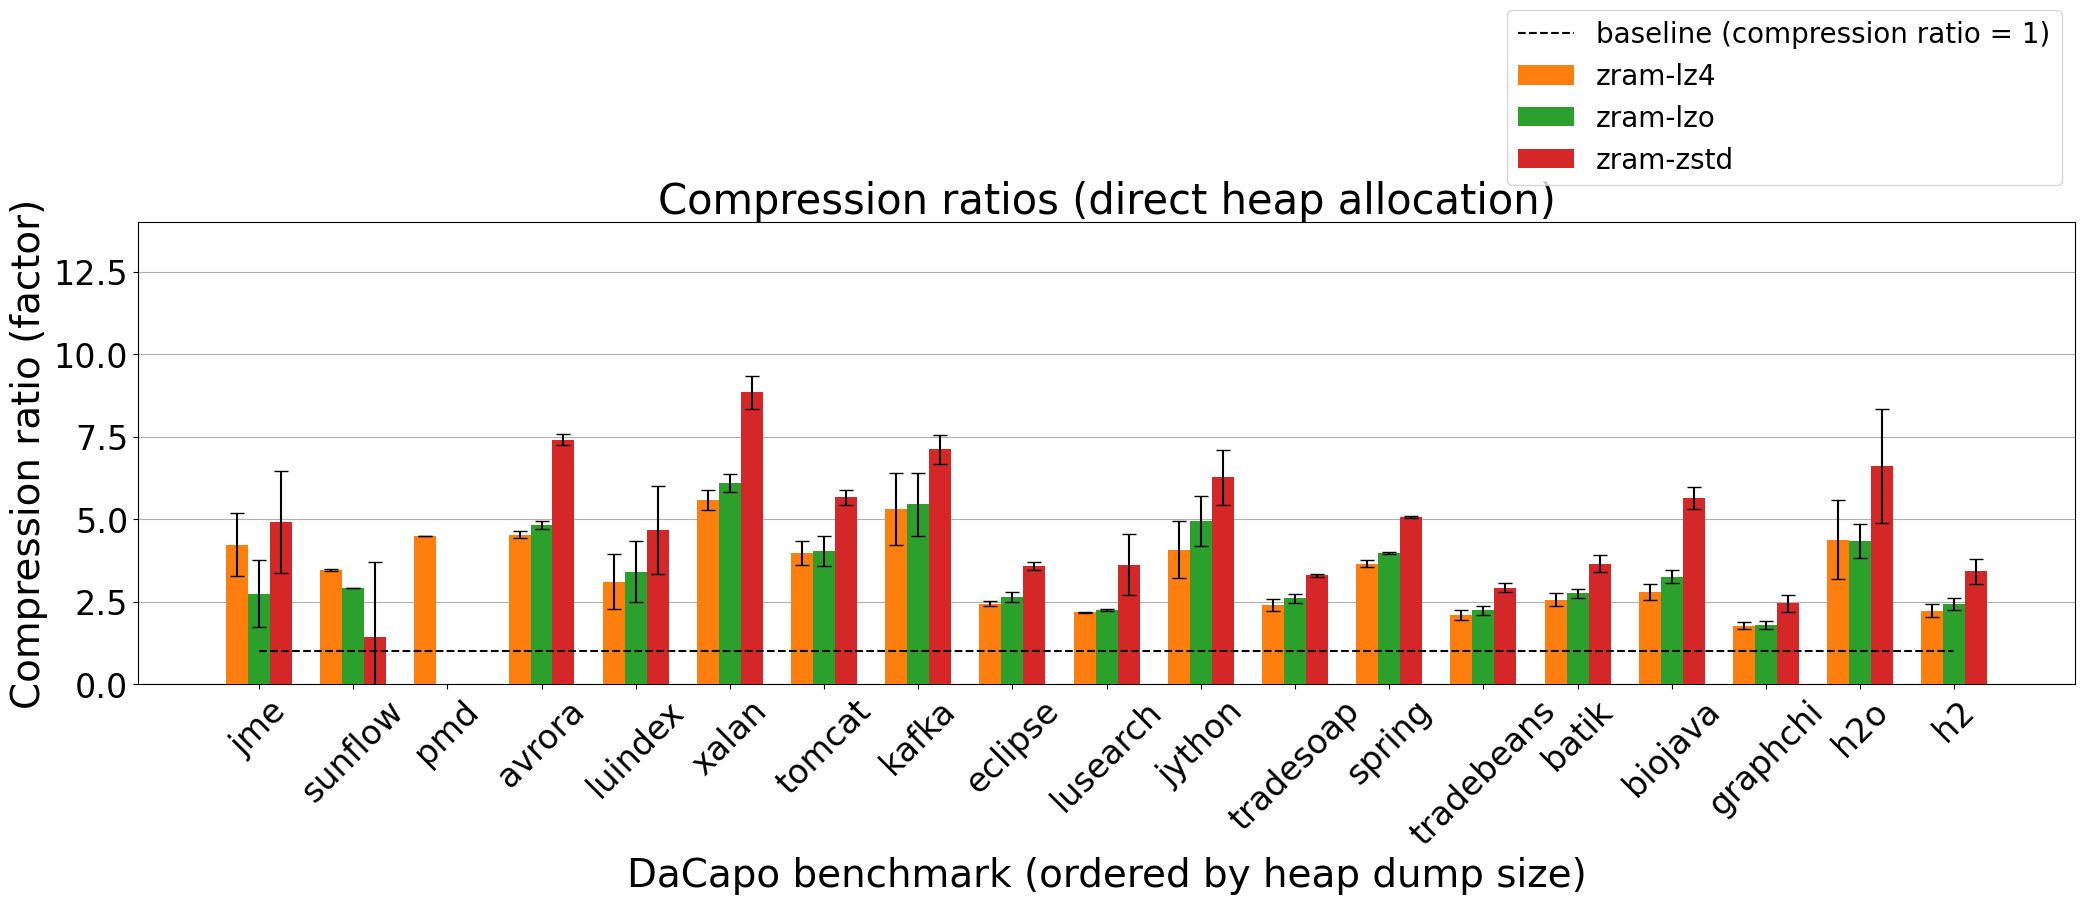

In [20]:
alib.grouped_barplot(
    df=df_aha,
    grouping_col="device",
    config_col="benchmark", 
    value_col="AVG_RATIO",
    error_col="RATIO_STDDEV",
    config_order=benchmarks_ordered, 
    grouping_order=["zram2", "zram0", "zram1"], 
    figsize=[25, 6],
    labels=["zram-lz4", "zram-lzo", "zram-zstd"],
    xlabel="DaCapo benchmark (ordered by heap dump size)",
    ylabel="Compression ratio (factor)",
    colors=["#ff7f0e", "#2ca02c", "#d62728"],
    show=False
)

nb = len(benchmarks_ordered)
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.ylim([0, 14])

plt.gca().get_yaxis().label.set_fontsize(28)
plt.gca().get_xaxis().label.set_fontsize(28)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
plt.xticks(rotation=45)

plt.legend(fontsize=20, bbox_to_anchor=(1, 1.05), loc="lower right")

plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-allocateheapat.png", bbox_inches="tight")
plt.title("Compression ratios (direct heap allocation)")
plt.gca().title.set_fontsize(30)
plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-allocateheapat-w-title.png", bbox_inches="tight")
plt.show()

In [12]:
print(sq("SELECT device, benchmark, AVG_RATIO FROM df_aha ORDER BY device, benchmark"))

   device   benchmark  AVG_RATIO
0   zram0      avrora       4.83
1   zram0       batik       2.76
2   zram0     biojava       3.26
3   zram0     eclipse       2.64
4   zram0    graphchi       1.81
5   zram0          h2       2.43
6   zram0         h2o       4.35
7   zram0         jme       2.75
8   zram0      jython       4.96
9   zram0       kafka       5.46
10  zram0     luindex       3.41
11  zram0    lusearch       2.26
12  zram0         pmd        NaN
13  zram0      spring       3.97
14  zram0     sunflow       2.93
15  zram0      tomcat       4.05
16  zram0  tradebeans       2.25
17  zram0   tradesoap       2.61
18  zram0       xalan       6.10
19  zram1      avrora       7.42
20  zram1       batik       3.66
21  zram1     biojava       5.64
22  zram1     eclipse       3.59
23  zram1    graphchi       2.46
24  zram1          h2       3.43
25  zram1         h2o       6.63
26  zram1         jme       4.91
27  zram1      jython       6.27
28  zram1       kafka       7.12
29  zram1 

In [13]:
sq("SELECT device, AVG(AVG_RATIO) from df_aha GROUP BY device")

,device,AVG(AVG_RATIO)
0,zram0,3.490556
1,zram1,4.817778
2,zram2,3.441579


# dumpy 

In [22]:
df_dumps = pd.read_csv("../../data/2025-10-22-time-22-35-51-dump-compression/zram_consolidated.csv")

In [23]:
df_dumps.columns

Index(['benchmark', 'dump_number', 'device', 'AVG_COMPR_SIZE_MB',
       'AVG_DATA_SIZE_MB', 'AVG_HUGE_PAGES', 'AVG_INCOMPRESSIBLE_DATA_MB',
       'AVG_RATIO', 'AVG_SAME_PAGES', 'HUGE_PAGES_AT_MAX_DATA_SIZE',
       'INITIAL_ENTRIES_SKIPPED', 'MAX_COMPR_SIZE_MB', 'MAX_DATA_SIZE_MB',
       'MAX_HUGE_PAGES', 'MAX_SAME_PAGES', 'RATIO_AT_MAX_DATA_SIZE',
       'RATIO_STDDEV', 'SAME_PAGES_AT_MAX_DATA_SIZE',
       'STARTUP_ENTRIES_SKIPPED'],
      dtype='object')

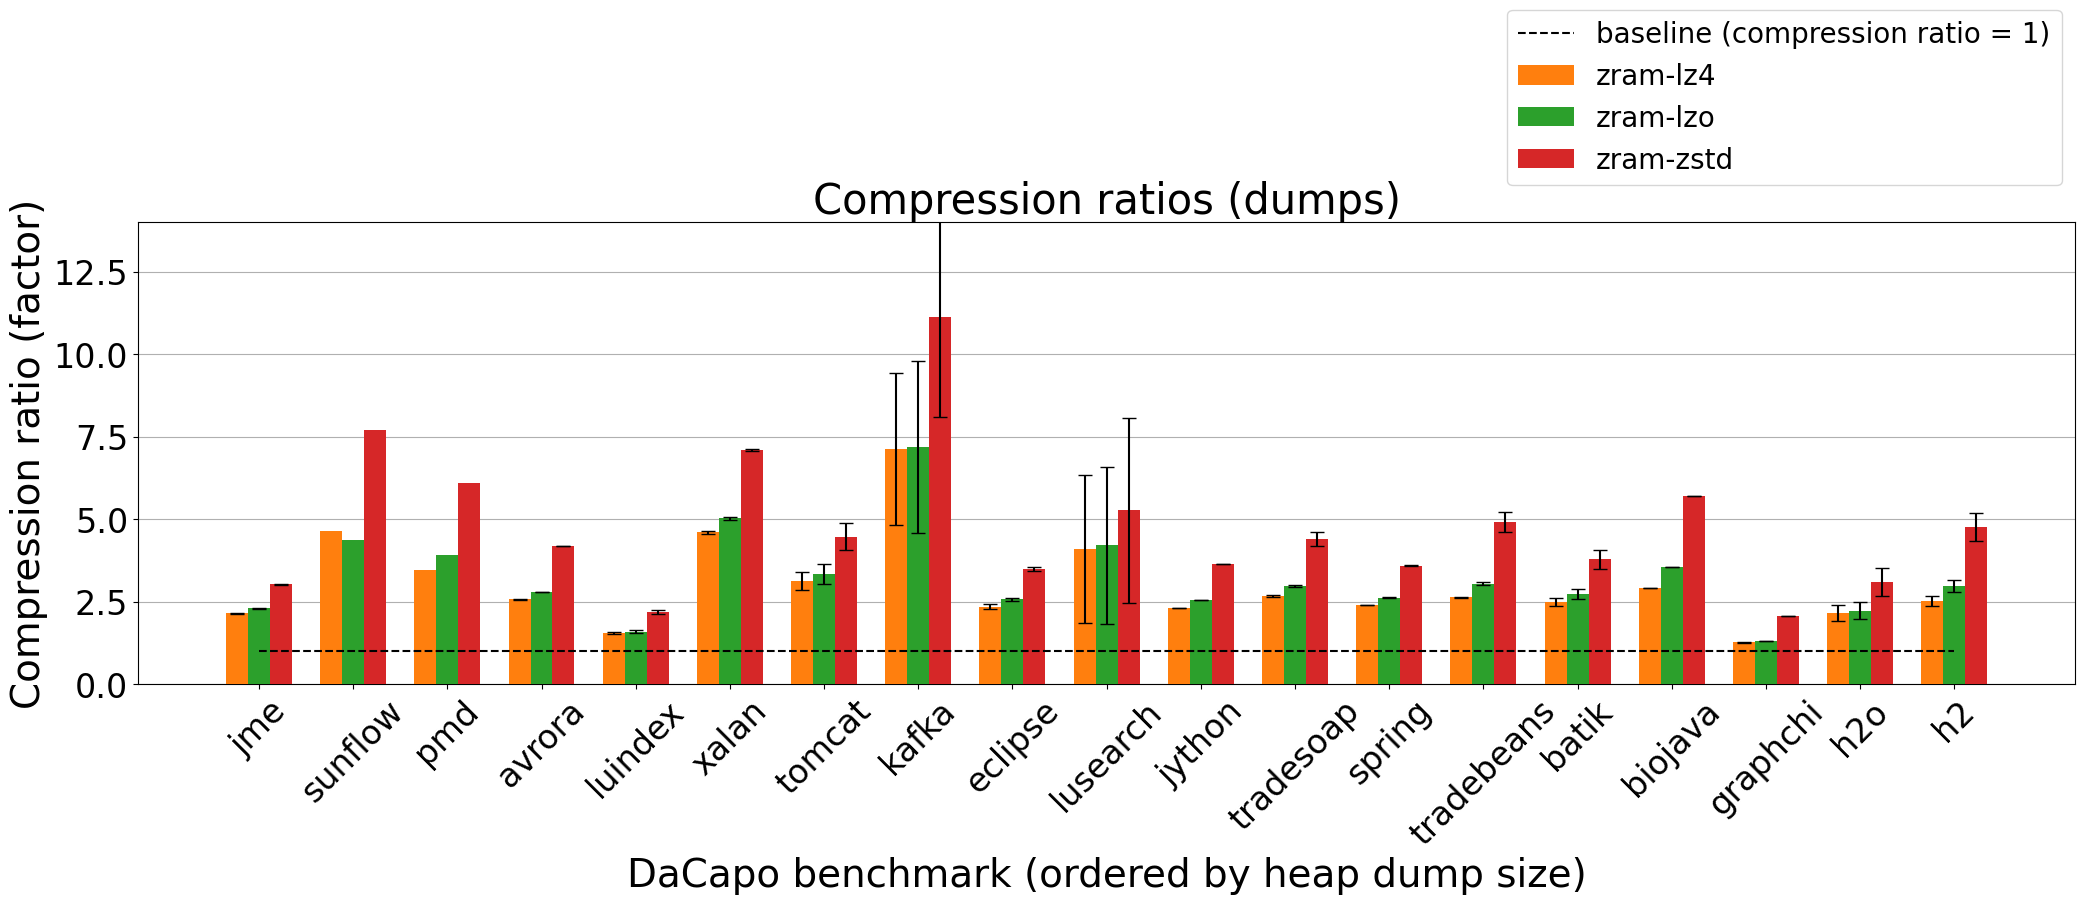

In [24]:
# Calculate aggregated data with pandas instead of SQL
df_agg = df_dumps.groupby(['benchmark', 'device'])['AVG_RATIO'].agg(['mean', 'std']).reset_index()
df_agg.columns = ['benchmark', 'device', 'ratio', 'err']

alib.grouped_barplot(
    df=df_agg,
    grouping_col="device",
    config_col="benchmark",
    value_col="ratio",
    error_col="err",
    config_order=benchmarks_ordered, 
    grouping_order=["zram2", "zram0", "zram1"], 
    figsize=[25, 6],
    labels=["zram-lz4", "zram-lzo", "zram-zstd"],
    xlabel="DaCapo benchmark (ordered by heap dump size)",
    ylabel="Compression ratio (factor)",
    colors=["#ff7f0e", "#2ca02c", "#d62728"],
    show=False
)

nb = len(benchmarks_ordered)
plt.plot(range(nb), np.ones(nb), linestyle='--', zorder=100, color="#000000", label="baseline (compression ratio = 1)") # draw a line at 1 for baseline purposes

plt.ylim([0, 14])

plt.gca().get_yaxis().label.set_fontsize(28)
plt.gca().get_xaxis().label.set_fontsize(28)
plt.gca().tick_params(axis='x', labelsize=24)
plt.gca().tick_params(axis='y', labelsize=24)
plt.xticks(rotation=45)

plt.legend(fontsize=20, bbox_to_anchor=(1, 1.05), loc="lower right")

plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios.png", bbox_inches="tight")
plt.title("Compression ratios (dumps)")
plt.gca().title.set_fontsize(30)
plt.savefig("../../processed-data/2025-10-22-dumps-final/compratios-w-title.png", bbox_inches="tight")
plt.show()


In [24]:
sq("""SELECT * 
      FROM (SELECT device, AVG(AVG_RATIO) AS ratio_dumps from df_dumps GROUP BY device)
            NATURAL JOIN (SELECT device, AVG(AVG_RATIO) AS ratio_direct FROM df_aha GROUP BY device)""")

,device,ratio_dumps,ratio_direct
0,zram0,3.119104,3.490556
1,zram1,4.558657,4.817778
2,zram2,2.885522,3.441579


In [11]:
sq("""SELECT * 
     FROM (SELECT benchmark, AVG(AVG_DATA_SIZE_MB) AS size_hprof from df_dumps GROUP BY benchmark) 
          NATURAL JOIN (SELECT benchmark, AVG(AVG_DATA_SIZE_MB) AS size_direct FROM df_aha GROUP BY benchmark)
     ORDER BY size_direct""")

,benchmark,size_hprof,size_direct
0,jme,12.850000,59.850000
1,sunflow,196.105000,93.653333
2,pmd,5141.070000,120.000000
3,avrora,24.506000,133.456667
4,luindex,17.592000,764.746667
5,xalan,39.832500,1047.543333
6,tomcat,53.266667,1207.343333
7,kafka,305.176000,1210.540000
8,eclipse,61.528000,1226.766667
9,lusearch,76.608000,1661.540000


# dumpy writes

In [13]:
dfwrites = pd.read_csv("../../data-raven3/2025-10-24-time-10-56-01-dump-write/master.csv")

In [14]:
with open("../../data-raven3/2025-10-24-time-10-56-01-dump-write/fio-config.txt") as f:
    print(f.read())

Devices: zram0 zram1 zram2
Total file size during runs: 34359738368
Block sizes: 100M
Numbers of processes: 1 64
Read/write type options: write
Sync I/O engines: sync
Dacapo benchmarks used: avrora batik biojava cassandra eclipse fop graphchi h2 h2o jme jython kafka luindex lusearch pmd spring sunflow tomcat tradebeans tradesoap xalan zxing
Number of dumps per bench: 2



In [15]:
dfwrites.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cdumpbc', 'cdumpno', 'cfile',
       'cbuffer_compress_percentage', 'cbuffer_compress_chunk', 'crwmixwrite',
       'readBW_bytes', 'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns',
       'avgreadlat', 'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc',
       'SYS_UTIL_perc', 'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc',
       'diskutil-TOTAL_READS(KB)', 'diskutil-TOTAL_WRITES(KB)',
       'diskutil-TOTAL_READS(MB)', 'diskutil-TOTAL_WRITES(MB)',
       'diskutil-TOTAL_READS(GB)', 'diskutil-TOTAL_WRITES(GB)',
       'diskutil-rMB/s', 'diskutil-wMB/s', 'diskutil-AVGRQ-SZ',
       'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

In [57]:
sq("""SELECT cdevice, cdumpbc, cdumpno, writeBW_bytes/(1024*1024*1024.0) AS writeBW
      FROM dfwrites
      WHERE cnproc=1 AND cdumpno=1 AND cdevice='zram-zstd'
      ORDER BY writeBW DESC""")

,cdevice,cdumpbc,cdumpno,writeBW
0,zram-zstd,kafka,1,0.903713
1,zram-zstd,lusearch,1,0.481268
2,zram-zstd,xalan,1,0.382360
3,zram-zstd,sunflow,1,0.313019
4,zram-zstd,tomcat,1,0.292151
5,zram-zstd,pmd,1,0.274894
6,zram-zstd,h2,1,0.271743
7,zram-zstd,biojava,1,0.254770
8,zram-zstd,graphchi,1,0.244612
9,zram-zstd,avrora,1,0.238360


In [83]:
sq("""SELECT cdevice, cdumpbc, cdumpno, writeBW_bytes/(1024*1024*1024.0) AS writeBW
      FROM dfwrites
      WHERE cnproc=64 AND cdumpno=1 AND cdevice='zram-lzo'
      ORDER BY writeBW DESC""")

,cdevice,cdumpbc,cdumpno,writeBW
0,zram-lzo,kafka,1,16.200104
1,zram-lzo,lusearch,1,7.794961
2,zram-lzo,xalan,1,6.613757
3,zram-lzo,tomcat,1,5.161876
4,zram-lzo,h2,1,4.639941
5,zram-lzo,h2o,1,4.367575
6,zram-lzo,eclipse,1,4.214430
7,zram-lzo,sunflow,1,4.188447
8,zram-lzo,tradebeans,1,4.046355
9,zram-lzo,jme,1,3.979371


In [72]:
sq("""SELECT device, benchmark, AVG(AVG_RATIO) AS ratio, AVG(100* AVG_INCOMPRESSIBLE_DATA_MB/AVG_DATA_SIZE_MB) AS incompressible_perc
      FROM df_dumps
      WHERE device = 'zram2'
      GROUP BY benchmark
      ORDER BY ratio DESC""")

,device,benchmark,ratio,incompressible_perc
0,zram2,kafka,7.132500,6.640829
1,zram2,sunflow,4.660000,0.041030
2,zram2,xalan,4.613333,0.092598
3,zram2,lusearch,4.092500,21.607654
4,zram2,pmd,3.470000,0.001659
5,zram2,tomcat,3.140000,3.902988
6,zram2,biojava,2.910000,0.005872
7,zram2,tradesoap,2.670000,0.296627
8,zram2,tradebeans,2.640000,0.159278
9,zram2,avrora,2.572500,1.427442


In [81]:
sq("""SELECT device, benchmark, dump_number, AVG_RATIO AS ratio, 100* AVG_INCOMPRESSIBLE_DATA_MB/AVG_DATA_SIZE_MB AS incompressible_perc
      FROM df_dumps
      WHERE device = 'zram2' AND benchmark = 'luindex'
      ORDER BY ratio DESC""")

,device,benchmark,dump_number,ratio,incompressible_perc
0,zram2,luindex,19,1.58,25.378558
1,zram2,luindex,9,1.57,28.177966
2,zram2,luindex,29,1.56,26.385390
3,zram2,luindex,39,1.51,38.010305


# dumpy reads

In [68]:
dfreads = pd.read_csv("../../data-raven3/2025-10-24-time-18-07-45-dump-read/master.csv")

In [70]:
sq("""SELECT cdevice, cdumpbc, cdumpno, readBW_bytes/(1024*1024*1024.0) AS readBW
      FROM dfreads
      WHERE cnproc=64 AND cdumpno=1 AND cdevice='zram-zstd'
      ORDER BY readBW DESC""")

,cdevice,cdumpbc,cdumpno,readBW
0,zram-zstd,kafka,1,42.229730
1,zram-zstd,lusearch,1,26.172529
2,zram-zstd,xalan,1,21.374829
3,zram-zstd,h2,1,17.341842
4,zram-zstd,tomcat,1,16.604676
5,zram-zstd,spring,1,15.192027
6,zram-zstd,h2o,1,15.111219
7,zram-zstd,eclipse,1,15.103915
8,zram-zstd,tradebeans,1,14.859724
9,zram-zstd,biojava,1,14.609631
